# CHAPTER3. 분류
> ## 차례
> ### 1. MNIST
> ### 2. 이진 분류기 훈련
> ### 3. 성능 측정
> ### 4. 다중 분류
> ### 5. 에러 분석
> ### 6. 다중 레이블 분류
> ### 7. 다중 출력 분류


<center><img src="https://drive.google.com/uc?export=view&id=1o9Ao8UxSIzbdzB22C9TJYp0LbQK5laX8"></center>


### 분류란?
* 지도학습의 일종으로, 이산형 변수인 target 값을 예측하는 task


## 1. MNIST
* 7만개의 숫자를 손글씨로 나타낸 데이터셋

<center><img src="https://drive.google.com/uc?export=view&id=1iouLWFovDUOt_-hNR0_oG2NSX_5C_Wku"></center>

#### Dataset 불러오기
* sklearn의 fetch_openml()함수를 이용하여 'mnist_784'라는 객체(dataset) 불러옴
* 해당 객체는 사전 자료형처럼 사용 가능

In [113]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

#### 이미지('data')를 이용하여 숫자('target')을 예측하는 문제이므로 독립변수와 종속변수에 각 값을 할당
* data는 7만 개의 이미지가 있고, 각 이미지에는 784($28*28$)개의 특성이 존재
* 각 특성은 0(흰색)부터 255(검은색)까지 픽셀의 강도를 표시
* 레이블도 7만 개의 이미지에 대한 숫자가 할당 되어있음(0~9사이의 숫자)

In [114]:
X, y = mnist["data"], mnist["target"]
print(f'X shape: {X.shape} \ny shape: {y.shape}')

X shape: (70000, 784) 
y shape: (70000,)


#### (예시)첫번째 이미지와 레이블

<function matplotlib.pyplot.show>

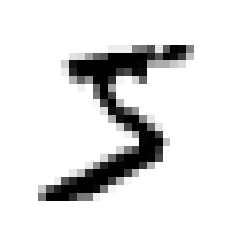

In [115]:
import matplotlib as mpl
import matplotlib .pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt. axis("off")
plt.show

In [116]:
y[0]

'5'

####그림 출력 함수

In [117]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

#### 레이블이 문자형으로 지정되어 있기 때문에 정수형으로 변환

In [118]:
import numpy as np

y = y.astype(np.uint8)

#### 모델 훈련에 앞서 훈련세트와 테스트세트로 분할

In [119]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 2. 이진 분류기 훈련
#### 이미지가 숫자 5를 나타내는지에 대한 여부 판단
* 0(False): 숫자 5를 나타내지 않음
* 1(True): 숫자 5를 나타냄

In [120]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#### 확률적 경사 하강법(SGD) 분류기를 이용하여 이미지 분류
* 선, 평면, 초평면을 이용하여 2개의 클래스를 분류
* sklearn의 SGDClassifier를 호출한 후, ```fit``` 함수를 이용하여 학습
* [확률적 경사 하강법 분류기 detail](https://scikit-learn.org/stable/modules/sgd.html)

In [121]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

#### 5를 나타내는 이미지에 대해 올바르게 예측된 것을 확인

In [122]:
sgd_clf.predict([some_digit]) # some_digit은 앞서 예시로 봤던 이미지!

array([ True])

## 3. 성능 측정
#### 분류기의 성능을 측정하는 방법
> 1) 교차 검증을 활용한 정확도 측정 <br>
> 2) 정밀도/재현율 <br>
> 3) AUC 측정 <br>

### 3.1 교차 검증을 활용한 정확도 측정
* ```cv=3```: 3-fold사용
* ```scoring="accuracy"```: 정확도를 측정

In [123]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### 정확도의 문제점
* class가 불균형 할 때 문제 발생
* 분류기A와 분류기 B 중 더 좋아보이는 모델은 B
* 하지만 accuracy를 기준으로 모델을 판단하면 A가 더 좋은 모델로 판단됨
<center><img src="https://drive.google.com/uc?export=view&id=1rhuNG3yN8AdKwbpCX1cZ5eDHWdcHz-Rg"></center>

#### 모든 샘플에 대해 ```False```로 예측하는 분류기 생성

In [124]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

#### 기존 분류기(SGDClassifier) 못지 않게 높은 정확도

In [125]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 3.2 오차 행렬
* 교차 검증을 이용하여 accuracy 대신 confusion matrix(오차 행렬)를 확인

In [126]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [127]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)

cm

array([[53892,   687],
       [ 1891,  3530]])

<center><img src="https://drive.google.com/uc?export=view&id=12vbgPyFMRsHDnqqc-_p7UoBn2A6yhTeC"></center>

* True Positives : 1인 레이블을 1이라 하는 경우를 True Positives라고 한다. -> 관심 범주를 정확하게 분류한 값.

* False Negatives : 1인 레이블을 0이라 하는 경우를 False Negatives라고 한다. -> 관심 범주가 아닌것으로 잘못 분류함.

* False Positives : 0인 레이블을 1이라 하는 경우를 False Positives라고 한다. -> 관심 범주라고 잘못 분류함.

* True Negatives : 0인 레이블을 0이라 하는 경우를 True Negatives라고 한다. -> 관심 범주가 아닌것을 정확하게 분류.

#### 완벽한 분류기의 경우를 확인

* FN, FP가 모두 0

In [128]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 3.3 정밀도와 재현율
###<center>$정밀도=\frac{TP}{TP+FP}$</center>
<center>예시) 메일의 스펨여부를 판단할 때</center>

###<center>$재현율=\frac{TP}{TP+FN}$</center>
<center>예시) 환자의 암 여부를 판단할 때</center><br>

<center><img src="https://drive.google.com/uc?export=view&id=1IDaRVYizbHWoyN8sQ0JCYya5rfgh7bSP"></center>

* 분류기가 실제 양성인 샘플 하나만 양성으로 분류하는 경우, 100%의 정밀도를 얻을 수 있음
* 즉, 정밀도는 재현율과 같이 사용하는 것이 일반적임 <br>

In [129]:
from sklearn.metrics import precision_score, recall_score

print(f'precision: {precision_score(y_train_5, y_train_pred)}')
print(f'recall: {recall_score(y_train_5, y_train_pred)}')

precision: 0.8370879772350012
recall: 0.6511713705958311


#### 정밀도와 재현율을 어떻게 한번에 고려하지?
> F1 score: 정밀도와 재현율의 조화(harmony)평균 <br>
> F1 score은 데이터셋이 unbalance label일 때 유용함!

<center><img src="https://drive.google.com/uc?export=view&id=1n0BCE9D3BC6d4_aEe6YrRCmS4DsZOM-k"></center>


In [130]:
from sklearn.metrics import f1_score
print(f'F1 score: {f1_score(y_train_5, y_train_pred)}')

F1 score: 0.7325171197343846


#### 일반적으로, F1 score는 위와 같은 식을 사용하지만 정밀도와 재현율을 다르게 반영하고 싶으면 아래와 같이 가중치($\alpha$, $\beta$)를 적용하는 식으로 사용하기도 함!

<center><img src="https://drive.google.com/uc?export=view&id=11oFTObT3ANR1YtBTQ2sf2C9FguGWkTtn"></center>

### 3.4 정밀도/재현율 트레이드 오프
* 각 샘플에 대해 분류기는 output을 score로 나타남
* 각 score에 대해 임계값(threshold, default=0.5)를 정해서 클래스를 분류
* 아래 그림은 임계치를 다르게 주면서 정밀도와 재현율의 변화를 나타냄(trade-off가 존재!!)

<center><img src="https://drive.google.com/uc?export=view&id=1sruw5K1ksSbT_uGvRT5dUIcYLVGyCuR6"></center>

####```decision_function```을 이용하여 한 가지 샘플의 score를 도출

In [131]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

#### threshold를 다르게 줬을 때, 분류기의 결과가 달라짐

In [132]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(f'threshold=0일 때 결과: {y_some_digit_pred}')

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(f'threshold=8000일 때 결과: {y_some_digit_pred}')

threshold=0일 때 결과: [ True]
threshold=8000일 때 결과: [False]


####```method="decision_function"```을 통해 score를 반환받도록 지정

In [133]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

####```precision_recall_curve```로 가능한 모든 threshold에 대한 정밀도와 재현율을 표현 

In [134]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#### 정밀도와 재현율의 trade-off를 확인하기 위한 그래프

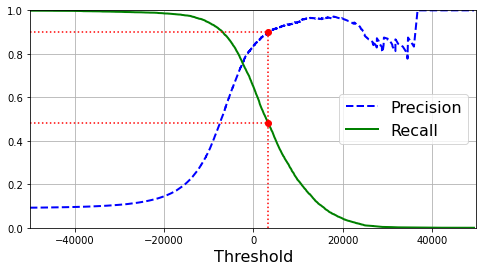

In [135]:
# 정밀도와 재현율 그래프 그리기. x 축은 임곗값을 가리킴.
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) # 정밀도 어레이 마지막 항목 무시
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)        # 재현율 어레이 마지막 항목 무시
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])            

# 정밀도 90%가 달성되는 지점에서의 재현율과 임곗값
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# 빨강 점과 빨강 점선 그리기
plt.figure(figsize=(8, 4))                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  # 수직 빨강 점선
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                 # 위 수평 빨강 점선
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")  # 아래 수평 빨강 점선
plt.plot([threshold_90_precision], [0.9], "ro")                              # 위 빨강 점 
plt.plot([threshold_90_precision], [recall_90_precision], "ro")              # 아래 빨강 점

plt.show()

#### 정밀도가 90%를 만족하며 최대한의 재현율을 보장하는 threshold 찾기
* ```np.argmax()```로 ```precisions>=90```을 만족하는 최소의 threshold를 도출

In [136]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

#### 도출된 threshold를 이용하여 모델의 output을 지정하고, 정밀도와 재현율을 확인

In [137]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(f'precision: {precision_score(y_train_5, y_train_pred_90)}')
print(f'recall: {recall_score(y_train_5, y_train_pred_90)}')

precision: 0.9000345901072293
recall: 0.4799852425751706


### 3.5 ROC 곡선
* 참 양성 비율(true positive rate, TPR)과 거짓 양성 비율(false positive rate, FPR) 사이의 관계
###<center>$TPR=\frac{TP}{FN+TP}$</center>
###<center>$FPR=\frac{FP}{TN+FP}$</center>
* TPR은 재현율로 해석할 수 있음!
* [참고 자료](https://angeloyeo.github.io/2020/08/05/ROC.html)

####```roc_curve```: 임곗값에 따른 FPR, TPR을 제공

In [138]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

#### SGD 분류기 모델의 TPR과 FPR 사이의 관계 그래프 그리기

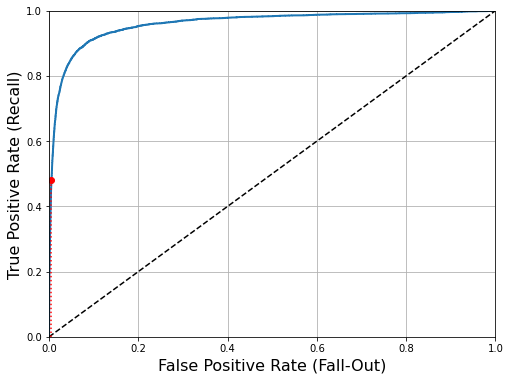

In [139]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

# 정밀도가 90%를 넘어설 때의 재현율(TPR, 참 양성 비율)에 해당하는 거짓 양성 비율(FPR)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]   # 0.0053 정도
# 빨강 점과 원점 사이의 실선 그리기
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # 수직 빨강 점선. 좌표는 (0.0053, 0.48) 정도
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # y축과 빨강 점 사이의 수평 빨강 점선(거의 안보임))
plt.plot([fpr_90], [recall_90_precision], "ro")               # 빨강 점
plt.show()

#### ROC 곡선을 수치화?
* ROC 곡선 아래의 넓이를 나타낸 **AUC** 이용<br>

In [140]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### Random forest와 SGD를 비교
* ```RandomForestClassifier```: random forest 분류기
* ```predict_proba```: output 값을 확률 형태로

In [141]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [142]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

#### Random forest가 SGD 보다 더 이상적인 ROC 곡선을 띄고 있음

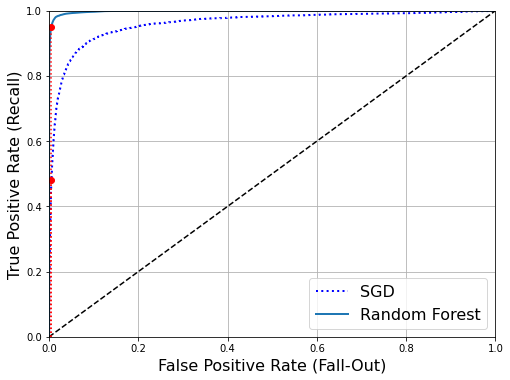

In [143]:
# 램덤 포레스트 분류기의 ROC 곡선 그리기
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]  # 90% FPR에 대응하는 TPR. 약 0.95

plt.figure(figsize=(8, 6))

# 파랑 점 곡선: SGD 분류기의 ROC 곡선
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
# 파랑 실선: 랜덤 포레스트 분류기의 ROC 곡선
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")      # 짧은 빵강 수직 점선
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # 아랫쪽 빨강 수평 점선 (거의 안보임)
plt.plot([fpr_90], [recall_90_precision], "ro")                  # 아래쪽 빨강 점. 좌표는 (0.0053, 0.48) 정도
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")        # 윗쪽 빨강 수평 점선 (거의 안보임)
plt.plot([fpr_90], [recall_for_forest], "ro")                    # 위쪽 빨강 점. 좌표는 (0.0053, 0.95) 정도
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [144]:
print(f"SGD의 AUC: {roc_auc_score(y_train_5, y_scores)}")
print(f"Random Forest의 AUC: {roc_auc_score(y_train_5, y_scores_forest)}")

SGD의 AUC: 0.9604938554008616
Random Forest의 AUC: 0.9983436731328145


## 4. 다중 클래스 분류
* 둘 이상의 클래스를 분류
* 이진 분류를 기본으로 하는 모델은 다음과 같은 전략으로 다중 분류를 수행
    * OvR(One-versus-the-Rest): 클래스마다 이진 분류기를 만들어서 가장 높은 결정점수를 낸 클래스를 선택
        * 대부분의 이진 알고리즘에서 사용   
    * OvO(One-versus-One): 가능한 두 개의 모든 클래스 조합에 대해 이진 분류기를 만듦. 가장 많이 양성으로 분류된 클래스를 선택
        * 훈련 세트의 크기에 민감한 알고리즘은 많은 분류기를 훈련시키는 것이 빠르므로 OvO 선호
    * 사이킷런에서는 모델에 따라 자동으로 OvR, OvO를 실행
    * SVM의 경우, OvO가 실행

In [145]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train[:1000], y_train[:1000]) # 연산량이 많아, 샘플을 1000개로 제한
svm_clf.predict([some_digit])

array([5], dtype=uint8)

#### 각 클래스의 점수 확인

In [146]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.75828215,  2.74956232,  6.13809559,  8.2853702 , -0.28728967,
         9.30119996,  0.74228825,  3.79256174,  7.20847395,  4.85762716]])

In [147]:
np.argmax(some_digit_scores)

5

In [148]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [149]:
svm_clf.classes_[5]

5

#### 강제적으로 OvR 방식 활용
* ```OneVsRestClassifier``` 활용

In [150]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])

OneVsRestClassifier(estimator=SVC(gamma='auto', random_state=42))

In [151]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

#### 모델의 수는 10개

In [152]:
len(ovr_clf.estimators_)

10

#### SGD와 Random forest는 다중 분류를 지원
* OvR이나 OvO를 적용할 필요가 없음

In [153]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

#### 실제 label(5)이 아닌 3으로 예측

In [154]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

#### 각 클래스에 배정된 점수

In [155]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

####간단한 스케일링(```StandardScaler```)을 이용하여 성능 향상

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## 5. 에러 분석
* SGD의 cross validation 결과로 confusion matrix 확인

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

conf_mx

#### confusion matrix를 그래프화

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

#### 사이킷런의 ```plot_confusion_matrix```를 이용하여 한번에 그래프화

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(sgd_clf, X_train, y_train, include_values=False, cmap='gray')

* 숫자 별 총 이미지의 개수로 나누어줌
* 오차율 행렬로 변환

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)  # 숫자별 총 이미지 개수
norm_conf_mx = conf_mx / row_sums

* 8로 잘못 분류되는 비율이 높아보임
* 3과 5 사이에 서로 잘못 분류되는 비율도 높아보임

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)  # 대각선을 0으로 채우기
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

plt.show()

#### 각 샘플을 직접 확인함으로써 모델의 보안점 탐색

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]  # 3을 3으로 예측한 샘플들
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]  # 3을 5로 예측한 샘플들
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]  # 5를 3으로 예측한 샘플들
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]  # 5를 5로 예측한 샘플들

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)  # 이미지 상단 왼편
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)  # 이미지 상단 오른편
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)  # 이미지 하단 왼편
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)  # 이미지 하단 오른편
plt.show()

## 6. 다중 레이블 분류
* 각 샘플에 여러가지 클래스가 존재하는 경우
    * 샘플이 홀수인지의 여부
    * 7보다 같거나 큰지의 여부

* ```np.c_```: 두 array를 합쳐줌
* 다중 레이블 분류를 지원하는 ```KNeighborsClassifier``` 모델을 사용

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # 7보다 같거나 큰지
y_train_odd = (y_train % 2 == 1) # 홀수인지
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

#### 다중 레이블 분류의 평가
* 다중 레이블 분류기를 평가하는 방법은 모델과 목적에 따라 다름
* 예를 들어 각 레이블의 F1 score를 구하고 레이블에 대한 가중치를 적용한 평균 점수 계산
    * 가중치 예시: 타겟 레이블에 속한 샘플 수인 지지도를 이용(샘플 수가 많은 클래스에 더 큰 가중치 부여)
* 아래 예시는 모든 레이블에 가중치를 동일하게 줌(```average="macro"```)


In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

## 7. 다중 출력 분류
* 다중 출력 분류는 다중 레이블 분류에서 각 레이블이 2개 이상의 값을 가질 때를 의미

#### 다중 출력 분류 예시
* 이미지에서 잡음을 제거하는 시스템
    * 다중 레이블: 각각의 픽셀에 대해 레이블(이진) 예측
    * 다중 출력: 각각의 픽셀에서 예측하는 레이블이 0부터 255 중 하나임

In [ ]:
# MNIST 훈련 세트의 모든 샘플에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

# MNIST 테스트 세트의 모든 샘플에 잡음 추가
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# 레이블은 사진 원본
y_train_mod = X_train
y_test_mod = X_test

#### 잡음이 추가된 이미지와 원본 이미지를 비교

In [ ]:
some_index = 0  # 0번 인덱스 

plt.subplot(121); plot_digit(X_test_mod[some_index])  # 잡음 추가된 이미지
plt.subplot(122); plot_digit(y_test_mod[some_index])  # 원본 이미지

plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)                       # 모델 훈련
clean_digit = knn_clf.predict([X_test_mod[some_index]])     # 각 픽셀에 7에 해당하는 값으로 채움

plot_digit(clean_digit)